<a href="https://colab.research.google.com/github/SeongBeomLEE/RecsysTutorial/blob/main/SASRec/SASRec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install python-box

In [2]:
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from box import Box

import warnings

warnings.filterwarnings(action='ignore')
torch.set_printoptions(sci_mode=True)

# 1. 학습 설정

In [3]:
config = {
    'data_path' : "/content/drive/MyDrive/RecsysTutorial/Data/MovieLens" , # 데이터 경로

    'max_len' : 50,
    'hidden_units' : 50, # Embedding size
    'num_heads' : 1, # Multi-head layer 의 수 (병렬 처리)
    'num_layers': 2, # block의 개수 (encoder layer의 개수)
    'dropout_rate' : 0.5, # dropout 비율
    'lr' : 0.001,
    'batch_size' : 128,
    'num_epochs' : 50,
    'num_workers' : 2,
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Box(config)

# 2. 데이터 전처리

In [4]:
class MakeSequenceDataSet():
    """
    SequenceData 생성
    """
    def __init__(self, config):
        self.config = config
        self.df = pd.read_csv(os.path.join(self.config.data_path, 'ratings.csv'))
        
        self.item_encoder, self.item_decoder = self.generate_encoder_decoder('movieId')
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder('userId')
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        self.df['item_idx'] = self.df['movieId'].apply(lambda x : self.item_encoder[x] + 1)
        self.df['user_idx'] = self.df['userId'].apply(lambda x : self.user_encoder[x])
        self.df = self.df.sort_values(['user_idx', 'timestamp']) # 시간에 따라 정렬
        self.user_train, self.user_valid = self.generate_sequence_data()

    def generate_encoder_decoder(self, col : str) -> dict:
        """
        encoder, decoder 생성

        Args:
            col (str): 생성할 columns 명
        Returns:
            dict: 생성된 user encoder, decoder
        """

        encoder = {}
        decoder = {}
        ids = self.df[col].unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id

        return encoder, decoder
    
    def generate_sequence_data(self) -> dict:
        """
        sequence_data 생성

        Returns:
            dict: train user sequence / valid user sequence
        """
        users = defaultdict(list)
        user_train = {}
        user_valid = {}
        group_df = self.df.groupby('user_idx')
        for user, item in group_df:
            users[user].extend(item['item_idx'].tolist())
        
        for user in users:
            user_train[user] = users[user][:-1]
            user_valid[user] = [users[user][-1]] # 마지막 아이템을 예측

        return user_train, user_valid
    
    def get_train_valid_data(self):
        return self.user_train, self.user_valid

In [5]:
class SASRecDataSet(Dataset):
    def __init__(self, user_train, max_len, num_user, num_item):
        self.user_train = user_train
        self.max_len = max_len
        self.num_user = num_user
        self.num_item = num_item
        self._all_items = set([i for i in range(1, self.num_item + 1)])

    def __len__(self):
        # 총 user의 수 = 학습에 사용할 sequence의 수
        return self.num_user

    def __getitem__(self, user): 
        
        user_seq = self.user_train[user]
        user_seq_len = len(user_seq)

        seq = user_seq[-(user_seq_len) : -1]
        seq = seq[-self.max_len :]

        pos = user_seq[-(user_seq_len - 1) : ]
        pos = pos[-self.max_len :]
        
        neg = random.sample(list(self._all_items - set(user_seq)), len(pos))
        
        seq = [0] * (self.max_len - len(seq)) + seq
        pos = [0] * (self.max_len - len(pos)) + pos
        neg = [0] * (self.max_len - len(neg)) + neg
        
        return np.array(seq, dtype=np.int32), np.array(pos, dtype=np.int32), np.array(neg, dtype=np.int32)

    def random_neg_sampling(self, rated_item : list, num_item_sample : int):
        nge_samples = random.sample(list(self._all_items - set(rated_item)), num_item_sample)
        return nge_samples

# 3. 모델

In [6]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(ScaledDotProductAttention, self).__init__()
        self.hidden_units = hidden_units
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, Q, K, V, mask):
        """
        Q, K, V : (batch_size, num_heads, max_len, hidden_units)
        mask : (batch_size, 1, max_len, max_len)
        """
        attn_score = torch.matmul(Q, K.transpose(2, 3)) / math.sqrt(self.hidden_units) # (batch_size, num_heads, max_len, max_len)
        attn_score = attn_score.masked_fill(mask == 0, -1e9)  # 유사도가 0인 지점은 -infinity로 보내 softmax 결과가 0이 되도록 함
        attn_dist = self.dropout(F.softmax(attn_score, dim=-1))  # attention distribution
        output = torch.matmul(attn_dist, V)  # (batch_size, num_heads, max_len, hidden_units) / # dim of output : batchSize x num_head x seqLen x hidden_units
        return output, attn_dist


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, hidden_units, dropout_rate):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads # head의 수
        self.hidden_units = hidden_units
        
        # query, key, value, output 생성을 위해 Linear 모델 생성
        self.W_Q = nn.Linear(hidden_units, hidden_units * num_heads, bias=False)
        self.W_K = nn.Linear(hidden_units, hidden_units * num_heads, bias=False)
        self.W_V = nn.Linear(hidden_units, hidden_units * num_heads, bias=False)
        self.W_O = nn.Linear(hidden_units * num_heads, hidden_units, bias=False)

        self.attention = ScaledDotProductAttention(hidden_units, dropout_rate)
        self.dropout = nn.Dropout(dropout_rate) # dropout rate
        self.layerNorm = nn.LayerNorm(hidden_units, 1e-6) # layer normalization

    def forward(self, enc, mask):
        """
        enc : (batch_size, max_len, hidden_units)
        mask : (batch_size, 1, max_len, max_len)
        
        """
        residual = enc # residual connection을 위해 residual 부분을 저장
        batch_size, seqlen = enc.size(0), enc.size(1)

        # Query, Key, Value를 (num_head)개의 Head로 나누어 각기 다른 Linear projection을 통과시킴
        Q = self.W_Q(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units) # (batch_size, max_len, num_heads, hidden_units)
        K = self.W_K(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units) # (batch_size, max_len, num_heads, hidden_units)
        V = self.W_V(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units) # (batch_size, max_len, num_heads, hidden_units)

        # Head별로 각기 다른 attention이 가능하도록 Transpose 후 각각 attention에 통과시킴
        Q, K, V = Q.transpose(1, 2), K.transpose(1, 2), V.transpose(1, 2) # (batch_size, num_heads, max_len, hidden_units)
        output, attn_dist = self.attention(Q, K, V, mask) # output : (batch_size, num_heads, max_len, hidden_units) / attn_dist : (batch_size, num_heads, max_len, max_len)

        # 다시 Transpose한 후 모든 head들의 attention 결과를 합칩니다.
        output = output.transpose(1, 2).contiguous() # (batch_size, max_len, num_heads, hidden_units) / contiguous() : 가변적 메모리 할당
        output = output.view(batch_size, seqlen, -1) # (batch_size, max_len, hidden_units * num_heads)

        # Linear Projection, Dropout, Residual sum, and Layer Normalization
        output = self.layerNorm(self.dropout(self.W_O(output)) + residual) # (batch_size, max_len, hidden_units)
        return output, attn_dist


class PositionwiseFeedForward(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(PositionwiseFeedForward, self).__init__()

        self.W_1 = nn.Linear(hidden_units, hidden_units)
        self.W_2 = nn.Linear(hidden_units, hidden_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.layerNorm = nn.LayerNorm(hidden_units, 1e-6) # layer normalization

    def forward(self, x):
        residual = x
        output = self.W_2(F.relu(self.dropout(self.W_1(x))))
        output = self.layerNorm(self.dropout(output) + residual)
        return output


class SASRecBlock(nn.Module):
    def __init__(self, num_heads, hidden_units, dropout_rate):
        super(SASRecBlock, self).__init__()
        self.attention = MultiHeadAttention(num_heads, hidden_units, dropout_rate)
        self.pointwise_feedforward = PositionwiseFeedForward(hidden_units, dropout_rate)

    def forward(self, input_enc, mask):
        """
        input_enc : (batch_size, max_len, hidden_units)
        mask : (batch_size, 1, max_len, max_len)
        """
        output_enc, attn_dist = self.attention(input_enc, mask)
        output_enc = self.pointwise_feedforward(output_enc)
        return output_enc, attn_dist


class SASRec(nn.Module):
    def __init__(self, num_user, num_item, hidden_units, num_heads, num_layers, max_len, dropout_rate, device):
        super(SASRec, self).__init__()

        self.num_user = num_user
        self.num_item = num_item
        self.hidden_units = hidden_units
        self.num_heads = num_heads
        self.num_layers = num_layers 
        self.device = device
        
        self.item_emb = nn.Embedding(num_item + 1, hidden_units, padding_idx=0)
        self.pos_emb = nn.Embedding(max_len, hidden_units) # learnable positional encoding
        self.dropout = nn.Dropout(dropout_rate)
        self.emb_layernorm = nn.LayerNorm(hidden_units, eps=1e-6)
        
        self.blocks = nn.ModuleList([SASRecBlock(num_heads, hidden_units, dropout_rate) for _ in range(num_layers)])
    
    def feats(self, log_seqs):
        """
        log_seqs : (batch_size, max_len)

        ex)
        log_seqs = [
                [1, 2, 3, 4, 5],
                [0, 0, 0, 1, 2],
                [0, 0, 1, 2, 3]
        ]
        
        """
        seqs = self.item_emb(torch.LongTensor(log_seqs).to(self.device)) # (batch_size, max_len, hidden_units)
        positions = np.tile(np.array(range(log_seqs.shape[1])), [log_seqs.shape[0], 1]) # (batch_size, max_len)
        seqs += self.pos_emb(torch.LongTensor(positions).to(self.device)) # (batch_size, max_len, hidden_units)
        seqs = self.emb_layernorm(self.dropout(seqs)) # LayerNorm

        # masking 
        mask_pad = torch.BoolTensor(log_seqs > 0).unsqueeze(1).unsqueeze(1) # (batch_size, 1, 1, max_len)
        mask_time = (1 - torch.triu(torch.ones((1, 1, seqs.size(1), seqs.size(1))), diagonal=1)).bool() # (batch_size, 1, max_len, max_len)
        mask = (mask_pad & mask_time).to(self.device) # (batch_size, 1, max_len, max_len)
        for block in self.blocks: 
            seqs, attn_dist = block(seqs, mask)

        # (batch_size, max_len, hidden_units)
        return seqs
    
    def forward(self, log_seqs, pos_seqs, neg_seqs):
        """
        log_seqs : (batch_size, max_len)
        pos_seqs : (batch_size, max_len)
        neg_seqs : (batch_size, max_len)

        ex)
        log_seqs = [
                [1, 2, 3, 4, 5],
                [0, 0, 0, 1, 2],
                [0, 0, 1, 2, 3]
        ]
        
        """
        # 학습에 사용
        feats = self.feats(log_seqs)
        pos_embs = self.item_emb(torch.LongTensor(pos_seqs).to(self.device))
        neg_embs = self.item_emb(torch.LongTensor(neg_seqs).to(self.device))
        
        pos_logits = (feats * pos_embs).sum(dim=-1)
        neg_logits = (feats * neg_embs).sum(dim=-1)
        return pos_logits, neg_logits
    
    def predict(self, log_seqs, item_indices):
        # evaluation에 사용
        final_feats = self.feats(log_seqs)[:, -1, :]
        item_embs = self.item_emb(torch.LongTensor(item_indices).to(self.device))
        logits = item_embs.matmul(final_feats.unsqueeze(-1)).squeeze(-1)
        return logits

# 4. 학습 함수

In [7]:
def train(model, criterion, optimizer, data_loader):
    model.train()
    loss_val = 0
    for seq, pos, neg in data_loader:
        pos_logits, neg_logits = model(seq.cpu().numpy(), pos.cpu().numpy(), neg.cpu().numpy())
        pos_labels, neg_labels = torch.ones(pos_logits.shape, device=device), torch.zeros(neg_logits.shape, device=device)

        optimizer.zero_grad()
        indices = np.where(pos != 0)
        loss = criterion(pos_logits[indices], pos_labels[indices])
        loss += criterion(neg_logits[indices], neg_labels[indices])

        loss_val += loss.item()

        loss.backward()
        optimizer.step()
    
    loss_val /= len(data_loader)

    return loss_val

def evaluate(model, user_train, user_valid, max_len, sasrec_dataset, make_sequence_dataset):
    model.eval()

    NDCG = 0.0 # NDCG@10
    HIT = 0.0 # HIT@10

    num_item_sample = 100

    users = [user for user in range(make_sequence_dataset.num_user)]

    for user in users:
        seq = user_train[user][-max_len:]
        rated = user_train[user] + user_valid[user]
        items = user_valid[user] + sasrec_dataset.random_neg_sampling(rated_item = rated, num_item_sample = num_item_sample)
        with torch.no_grad():
            predictions = -model.predict(np.array([seq]), np.array(items))
            predictions = predictions[0]
            rank = predictions.argsort().argsort()[0].item()

        if rank < 10: #Top10
            NDCG += 1 / np.log2(rank + 2)
            HIT += 1

    NDCG /= len(users)
    HIT /= len(users)

    return NDCG, HIT

# 5. 학습

In [8]:
make_sequence_dataset = MakeSequenceDataSet(config = config)
user_train, user_valid = make_sequence_dataset.get_train_valid_data()

In [9]:
sasrec_dataset = SASRecDataSet(
    user_train = user_train, 
    max_len = config.max_len, 
    num_user = make_sequence_dataset.num_user, 
    num_item = make_sequence_dataset.num_item, 
    )

In [10]:
data_loader = DataLoader(
    sasrec_dataset, 
    batch_size = config.batch_size, 
    shuffle = True, 
    pin_memory = True,
    num_workers = config.num_workers,
    )

In [11]:
model = SASRec(
    num_user = make_sequence_dataset.num_user, 
    num_item = make_sequence_dataset.num_item, 
    hidden_units = config.hidden_units, 
    num_heads = config.num_heads, 
    num_layers = config.num_layers, 
    max_len = config.max_len, 
    dropout_rate = config.dropout_rate, 
    device = device,
    ).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [12]:
best_ndcg = 0
loss_list = []
ndcg_list = []
hit_list = []
for epoch in range(1, config.num_epochs + 1):
    tbar = tqdm(range(1))
    for _ in tbar:
        train_loss = train(
            model = model, 
            criterion = criterion, 
            optimizer = optimizer, 
            data_loader = data_loader)
        
        ndcg, hit = evaluate(
            model = model, 
            user_train = user_train, 
            user_valid = user_valid, 
            max_len = config.max_len,
            sasrec_dataset = sasrec_dataset, 
            make_sequence_dataset = make_sequence_dataset,
            )

        loss_list.append(train_loss)
        ndcg_list.append(ndcg)
        hit_list.append(hit)

        tbar.set_description(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

Epoch:   1| Train loss: 5.89685| NDCG@10: 0.05035| HIT@10: 0.10730: 100%|██████████| 1/1 [00:04<00:00,  4.15s/it]
Epoch:   2| Train loss: 5.71095| NDCG@10: 0.04935| HIT@10: 0.11773: 100%|██████████| 1/1 [00:04<00:00,  4.89s/it]
Epoch:   3| Train loss: 5.66691| NDCG@10: 0.05093| HIT@10: 0.11773: 100%|██████████| 1/1 [00:05<00:00,  5.40s/it]
Epoch:   4| Train loss: 5.56942| NDCG@10: 0.05241| HIT@10: 0.12072: 100%|██████████| 1/1 [00:06<00:00,  6.53s/it]
Epoch:   5| Train loss: 5.47815| NDCG@10: 0.05338| HIT@10: 0.12072: 100%|██████████| 1/1 [00:04<00:00,  4.28s/it]
Epoch:   6| Train loss: 5.36596| NDCG@10: 0.05840| HIT@10: 0.12519: 100%|██████████| 1/1 [00:03<00:00,  3.25s/it]
Epoch:   7| Train loss: 5.30521| NDCG@10: 0.06073| HIT@10: 0.13413: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]
Epoch:   8| Train loss: 5.17374| NDCG@10: 0.05778| HIT@10: 0.12966: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]
Epoch:   9| Train loss: 5.00715| NDCG@10: 0.06416| HIT@10: 0.14307: 100%|██████████| 1/1

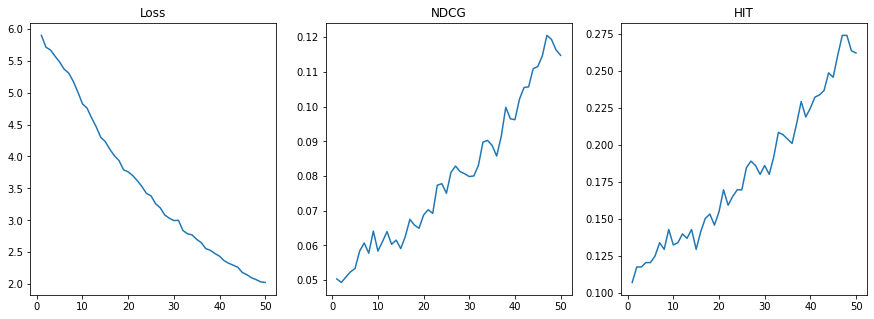

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax = ax.flatten()
epochs = [i for i in range(1, config.num_epochs + 1)]

ax[0].plot(epochs, loss_list)
ax[0].set_title('Loss')

ax[1].plot(epochs, ndcg_list)
ax[1].set_title('NDCG')

ax[2].plot(epochs, hit_list)
ax[2].set_title('HIT')
plt.show()